In [1]:
import numpy as np
import os
import absl
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.random as nrand
import pickle
from FixedPointStore import FixedPointStore
from FixedPointSearch import FixedPointSearch
import pickle
import tables
import time
from AdaptiveGradNormClip import AdaptiveGradNormClip
from AdaptiveLearningRate import AdaptiveLearningRate


TensorFlow 1.x selected.
No display found. Using non-interactive Agg backend.


In [4]:
class FlipFlop:
#Hyperparameters
    
    hyp_dict = \
    {'time' : 100,
    'bits' : 3 ,
    'num_steps' : 6,
    'batch_size' : 64,
    'state_size' : 64 ,
    'num_classes' : 2,
    'p': 0.2,
    'learning_rate' :0.01,
    'c_type':'UGRNN'
    }
    '''
    Architectures: 
    Vanilla, UG-RNN, GRU, LSTM
    
    Activation: 
    Tanh, relu
    
    Num_units:
    64, 128, 256 
    
    L2 regularization: 
    1e-5, 1e-4, 1e-3, 1e-2
    '''
    def __init__(self,
        time = hyp_dict['time'],
        bits = hyp_dict['bits'],
        num_steps = hyp_dict['num_steps'],
        batch_size = hyp_dict['batch_size'],
        state_size = hyp_dict['state_size'],
        num_classes = hyp_dict['num_classes'],
        learning_rate = hyp_dict['learning_rate'],
        p = hyp_dict['p'],
        c_type = hyp_dict['c_type'],
        l2 = 0.01,
        _seed = 400,
        **hps):
      
        self.seed = _seed
        self.time = time
        self.new_lr = 0
        self.hps = hps
        self.cell = None
        self.activation = 'tanh'
        self.lr_update = 0
        self.bits = bits
        self.fps = None
        self.alr_hps = {}#{'initial_rate': 1.0, 'min_rate': 1e-5}
        self.grad_global_norm = 0
        self.grad_norm_clip_val = 0
        self.dtype = tf.float32
        self.opt = 'norm'
        self.l2_loss = l2
        # self.adaptive_learning_rate = AdaptiveLearningRate(**self.alr_hps)
        # self.adaptive_grad_norm_clip = AdaptiveGradNormClip(**{})
        self.num_steps = num_steps
        self.num_steps =num_steps 
        self.batch_size = batch_size 
        self.state_size = state_size 
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.p = p  
        self.graph = 0
        self.chkpt = None
        self.c_type = c_type    
        self.sess = 0
        self.test_data = []

        np.random.seed(self.seed)

    def flip_flop(self, p = 0, plot=False):

      unsigned_inp = np.random.binomial(1,0.2,[self.batch_size,self.time,self.bits])
      unsigned_out = 2*np.random.binomial(1,0.5,[self.batch_size,self.time,self.bits]) -1 



      inputs = np.multiply(unsigned_inp,unsigned_out)
      inputs[:,0,:] = 1
      output = np.zeros_like(inputs)
      for trial_idx in range(self.batch_size):
          for bit_idx in range(self.bits):
              input_ = np.squeeze(inputs[trial_idx,:, bit_idx])
              t_flip = np.where(input_ != 0)
              for flip_idx in range(np.size(t_flip)):
                  # Get the time of the next flip
                  t_flip_i = t_flip[0][flip_idx]

                  '''Set the output to the sign of the flip for the
                  remainder of the trial. Future flips will overwrite future
                  output'''
                  output[trial_idx, t_flip_i:, bit_idx] = \
                      inputs[trial_idx, t_flip_i, bit_idx]

      
      if plot:
        plt.plot(inputs[0,:,0])
        plt.plot(output[0,:,0])
        plt.xlabel("time")
        plt.ylabel("Bit 0")
        plt.show()
        plt.plot(inputs[0,:,1])
        plt.plot(output[0,:,1])
        plt.xlabel("time")
        plt.ylabel("Bit 1")
        plt.show()
        plt.plot(inputs[0,:,2])
        plt.plot(output[0,:,2])
        plt.xlabel("time")
        plt.ylabel("Bit 2")
        plt.show()


      return {'inputs': inputs, 'output': output}

    
    def data_batches(self,num_batches,seed=None, save =False):
      batch_list = []
      if seed is not None:
        # self.seed = seed
        np.random.seed(seed)
      t1 = round(time.time()//1e6)
      total = 0
      for i in range(num_batches):

        single_batch = self.flip_flop()
        batch_list.append(single_batch)
        t2 = round((time.time()-t1)//1e6, 3)
        total +=t2
        # if i ==0:
        # print('time to generate' + 'batch'+str(i)+ 'is ', total)
        t1 = t2
        
      self.save_data(batch_list)
          # del(batch_list)
          # batch_list = []


      print('total time is %f', total)
      return batch_list
    def setup_optimizer(self, loss):

      decay = tf.train.exponential_decay(self.hps['lrate'],self.global_step,64,self.hps['decay'])
      optimizer = tf.train.MomentumOptimizer(decay,self.hps['moment'],use_nesterov=False)
      # optimizer = tf.train.AdamOptimizer(learning_rate=self.hps['lrate'])
      gradients, variables = zip(*optimizer.compute_gradients(loss,tf.trainable_variables()))
      gradients = [
          None if gradient is None else tf.clip_by_norm(gradient, hps['norm'])
          for gradient in gradients]
      train_op = optimizer.apply_gradients(zip(gradients, variables))

      return train_op
      
    def save_data(self, array):
      dir_name = os.getcwd()+'/data_'+str(self.seed)+'/'
      if not os.path.exists(os.path.dirname(dir_name)):
        os.makedirs(os.path.dirname(dir_name))

      filename  = dir_name+'data.npy'   
      f =  open(filename,'wb')
      np.save(f, np.array(array) ,allow_pickle=True)

    def restore_data(self, path):
      file = open(path,'rb')
      restore_data = np.load(file, allow_pickle=True)
      # file.close()
      # data = pickle.loads(restore_data,encoding='latin1')
      return restore_data

    def reset_graph(self):
        if 'sess' in globals() and self.sess:
            self.sess.close()
        tf.reset_default_graph()
    def is_lstm(self,x):
      if isinstance(x, tf.nn.rnn_cell.BasicLSTMCell):

        return True
      if isinstance(x, tf.nn.rnn_cell.LSTMStateTuple):
        return True

      return False

    def unroll_LSTM(self,lstm_cell, inputs, initial_state):

      assert (self.is_lstm(lstm_cell)),('lstm_cell is not an LSTM.')
      assert (self.is_lstm(initial_state)),('initial_state is not an LSTMStateTuple.')

      ''' Add ops to the graph for getting the complete LSTM state
      (i.e., hidden and cell) at every timestep.'''
      n_time = inputs.shape[1].value
      hidden_list = []
      cell_list = []

      prev_state = initial_state

      for t in range(n_time):

          input_ = inputs[:,t,:]

          _, state = lstm_cell(input_, prev_state)

          hidden_list.append(state.h)
          cell_list.append(state.c)
          prev_state = state

      c = tf.stack(cell_list, axis=1)
      h = tf.stack(hidden_list, axis=1)

      return tf.nn.rnn_cell.LSTMStateTuple(c=c, h=h)    
    def setup_model(self):
      
      self.reset_graph()
      x = tf.placeholder(tf.float32, [self.batch_size, self.time, self.bits], name='input_placeholder')
      y = tf.placeholder(tf.float32, [self.batch_size, self.time, self.bits], name='labels_placeholder')

      if self.c_type == 'Vanilla':
        if self.activation == 'tanh':
          self.cell = tf.nn.rnn_cell.BasicRNNCell(self.state_size,reuse=tf.AUTO_REUSE, activation=tf.nn.tanh)
        else:
          self.cell = tf.nn.rnn_cell.BasicRNNCell(self.state_size,reuse=tf.AUTO_REUSE, activation=tf.nn.relu)

      if self.c_type == 'GRU':
        if self.activation == 'tanh':
          self.cell = tf.nn.rnn_cell.GRUCell(self.state_size,reuse=tf.AUTO_REUSE, activation=tf.nn.tanh)
        else:
          self.cell = tf.nn.rnn_cell.GRUCell(self.state_size,reuse=tf.AUTO_REUSE, activation=tf.nn.relu)

      if self.c_type == 'UGRNN':
        if self.activation == 'tanh':
          self.cell = tf.contrib.rnn.UGRNNCell(self.state_size,reuse=tf.AUTO_REUSE, activation=tf.nn.tanh)
        else:
          self.cell = tf.contrib.rnn.UGRNNCell(self.state_size,reuse=tf.AUTO_REUSE, activation=tf.nn.relu)

      if self.c_type == 'LSTM':
        if self.activation == 'tanh':
          self.cell = tf.nn.rnn_cell.BasicLSTMCell(self.state_size,reuse=tf.AUTO_REUSE,state_is_tuple=True, activation=tf.nn.tanh)
        else:
          self.cell = tf.nn.rnn_cell.BasicLSTMCell(self.state_size,reuse=tf.AUTO_REUSE,state_is_tuple=True, activation=tf.nn.relu)

      init_state = self.cell.zero_state(self.batch_size, dtype=tf.float32)
      if self.c_type == 'LSTM':
        rnn_outputs = self.unroll_LSTM(self.cell,x,init_state)
        hiddens = rnn_outputs.h
      else:
        rnn_outputs, final_state = tf.nn.dynamic_rnn(self.cell, x, initial_state=init_state,)
        hiddens = rnn_outputs
      """
      rnn_outputs gives out rnn hidden states ht which is of the size [batch_size, timestep, state_size]
    
      """
      scale = 1.0 / np.sqrt(self.state_size)
      W = np.multiply(scale,np.random.randn(self.state_size, self.bits))
      b = np.zeros(self.bits)
      # with tf.variable_scope('losses',reuse=tf.AUTO_REUSE):
      #     W = tf.get_variable('W', [self.state_size , self.bits])
      #     b = tf.get_variable('b', [self.bits], initializer=tf.constant_initializer(0.0))

      with tf.variable_scope('losses',reuse=tf.AUTO_REUSE):
          W = tf.Variable(W,dtype=tf.float32)
          b = tf.Variable(b,dtype=tf.float32)

    
      logits = tf.tensordot(hiddens,W,axes=1) + b

      vars_   = tf.trainable_variables() 


      y_as_list =tf.reshape(y, [-1, self.bits]) #shape is flattened_tensor x bits
      logits_as_list = tf.reshape(logits, [-1, self.bits])
   
      lossL2 = tf.nn.l2_loss(W)*self.l2_loss

      losses = tf.squared_difference(logits, y) + lossL2
      total_loss = tf.reduce_mean(losses)
      self.global_step = tf.train.get_or_create_global_step()   
      train_step = self.setup_optimizer(total_loss)
      return {'losses':total_loss, 'train_step':train_step, 
              'hiddens':rnn_outputs, 
              'X':x, 'Y':y, 'predict':logits, 'init_state':init_state , 
              'saver' : tf.train.Saver(),'cell':self.cell, 'weights':W,
              'init':init_state}
    



    def train_network(self, num_epochs, verbose=True, save=False):
      num_epochs = num_epochs
      act = self.setup_model()
      epoch = 0
      training_loss = 0
      hidden = []
      saver = tf.train.Saver()
      max_lr_epoch=10
      learning_rate=1.0
      orig_decay = 0.93
      prev_val = 0
      curr_val = 0
      path = os.getcwd()+'/'+ self.c_type+str(num_epochs)
      iteration = 0
      with tf.Session() as sess:
        self.sess = sess
        self.sess.run(tf.global_variables_initializer())
        stop = False
        training_losses = []
        validation_loss = []
        for i in range(self.hps['epochs']):
          for i in range(num_epochs):
            data = self.flip_flop()
            ground_truth = data['output']
            tr_losses, training_step_, outputs, predict= \
                        self.sess.run([act['losses'],
                                      act['train_step'],
                                      act['hiddens'],
                                      act['predict']],
                                      feed_dict={act['X']:data['inputs'], act['Y']:data['output'], 
                                      })
            self.sess.run(self.global_step)
            if verbose and i%100==0:
                print("Average training loss for Epoch", iteration, ":", tr_losses)
            if i%10==0:
              self.seed = 900
              # prev_val = validation_loss[i-10:i]
              test_data = self.flip_flop(p=0.96)

              feed_dict = {act['X']:test_data['inputs'],act['Y']:test_data['output']}
              
              hiddens, outputs, losses= self.sess.run([act['hiddens'],act['predict'],act['losses']],feed_dict=feed_dict)
              validation_loss.append(losses)

              # if len(validation_loss)>5:
              #   curr_val = np.mean(validation_loss[-100:])

              # print("moving average", curr_val)
              # if(losses>curr_val and curr_val>0 and i>1000):
              #   break
              # else:
              #   prev_val = curr_val
              # print('validation loss', losses)
            if tr_losses<2.0:
              training_losses.append(tr_losses)
            
            if iteration == 0:
              hidden.append(outputs)
            iteration +=1
            # if tr_losses<1e-02:
            #   break
        hidden.append(outputs)

        if(save):
          saver.save(self.sess, path)
      plt.plot(np.arange(len(training_losses)),training_losses)
      plt.plot(np.arange(0,len(training_losses),10),validation_loss,)
      plt.xlabel('iterations')
      plt.ylabel('losses')
      plt.show()
      
      return {'losses':training_losses, 'hidden':hidden, 'predictions':predict, 'truth':ground_truth, }

    def lstm_hiddens(self, graph):

      n_hidden = self.state_size
      [self.batch_size, self.time, self.bits] = np.array(self.test_data['inputs']).shape
      initial_state = graph['cell'].zero_state(self.batch_size, dtype=tf.float32)

      ''' Add ops to the graph for getting the complete LSTM state
      (i.e., hidden and cell) at every timestep.'''
      full_state_list = []
      # cur_state_min_one = 0
      for t in range(self.time):
          input_ = graph['X'][:,t,:]
          if t == 0:
              cur_state_min_one = initial_state
          else:
              cur_state_min_one = full_state_list[-1]

          _, states = graph['cell'](input_,cur_state_min_one)
          full_state_list.append(states)
      
      # print(states.c)

      '''Evaluate those ops'''
      ops_to_eval = [full_state_list]
      feed_dict = {graph['X']: self.test_data['inputs']}
      ev_full_state_list= \
          self.sess.run(ops_to_eval, feed_dict=feed_dict)

      '''Package the results'''
      h = np.zeros([self.batch_size, self.time, self.state_size]) # hidden states: bxtxd
      c = np.zeros([self.batch_size, self.time, self.state_size]) # cell states: bxtxd
      for t in range(self.time):
          h[:,t,:] = ev_full_state_list[0][t].h
          c[:,t,:] = ev_full_state_list[0][t].c

      ev_LSTMCellState = tf.nn.rnn_cell.LSTMStateTuple(h=h, c=c)
      return(ev_LSTMCellState)

    def hps_array(self):
      arch  = ['Vanilla', 'UGRNN', 'GRU', 'LSTM']
      activ = ['tanh' , 'relu']
      units = [64, 128, 256 ]
      l2_norm = [1e-5, 1e-4, 1e-3, 1e-2]
      hps_dict = {'arch':arch,
                  'activ':activ,
                  'units':units,
                  'l2_norm':l2_norm}
    
      hps_array = []
    
      for i in arch:
        for j in activ:
          for k in units:
            for l in l2_norm:
              hps_array.append({'arch':i,
                                'activ':j,
                                'units':k,
                                'l2_norm':l})
      return hps_array  

    def reload_from_checkpoints(self, chkpt_):
      model = self.setup_model()
 
      # self.is_root = hvd.rank() == 0
      self.chkpt = tf.train.get_checkpoint_state(chkpt_)
      # print(tf.trainable_variables())
      self.graph = model

      saver = tf.train.Saver()

      self.test_data = self.flip_flop()

      feed_dict = {self.graph['X']:self.test_data['inputs'],self.graph['Y']:self.test_data['output']}

      self.sess = tf.Session()
      saver.restore(self.sess, self.chkpt.model_checkpoint_path)

      # if self.is_root: print("successfully loaded from checkpoints")
      hiddens, outputs, losses, init= self.sess.run([self.graph['hiddens'],self.graph['predict'],self.graph['losses'], self.graph['init']],feed_dict=feed_dict)
      # print(self.graph['init'])
      if(self.c_type=='LSTM'):

        return({'hiddens':self.lstm_hiddens(self.graph),'predictions':outputs,'loss':losses,'truth':self.test_data['output'],'inputs':self.test_data['inputs']})
        
      else:
        
        return({'hiddens':hiddens,'predictions':outputs,'loss':losses, 'truth':self.test_data['output'],'inputs':self.test_data['inputs']})
    
    def run_validation(self):

      model = self.setup_model()
      self.seed = 900
      # self.is_root = hvd.rank() == 0
      # chkpt = tf.train.get_checkpoint_state(self.chkpt)
      # print(tf.trainable_variables())
      self.graph = model

      saver = tf.train.Saver()

      self.test_data = self.flip_flop(p=0.96)

      feed_dict = {self.graph['X']:self.test_data['inputs'],self.graph['Y']:self.test_data['output']}

      self.sess = tf.Session()
      saver.restore(self.sess, self.chkpt.model_checkpoint_path)

      # if self.is_root: print("successfully loaded from checkpoints")
      hiddens, outputs, losses, init= self.sess.run([self.graph['hiddens'],self.graph['predict'],self.graph['losses'], self.graph['init']],feed_dict=feed_dict)
      plt.plot(outputs[0,:,0])
      plt.plot(self.test_data['inputs'][0,:,0])
      plt.plot(self.test_data['output'][0,:,0])
      return losses


    def fixed_points(self):
      n_bits = 3
      inputs = np.zeros([1,n_bits])
      def save_hidden_states(hid,path):

          # print(path) 
          dir_name = path+'/fps_saver/' 
          try:
            if not os.path.exists(os.path.dirname(dir_name)):
              os.makedirs(os.path.dirname(dir_name))
          except:
            print('path exists')
          filename  = dir_name+'hiddens_'+'.p'   
          f =  open(filename,'wb')
          # print(self.__dict__)
          pickle.dump(hid,f)
          f.close()

      # pathlist = os.listdir(os.getcwd()+'/trained')
      # lis = reload_from_chkpt(rnn_object, chkptpath, plot=True)
      lis = self.reload_from_checkpoints('/content')
      save_hidden_states(lis['hiddens'], '/content')
      hps = {'activ': 'tanh', 
          'arch' : 'LSTM',
          'l2_norm' : 1e-05,
          'units' : 128,
          'seed':400 }
      self.fps = FixedPointSearch(
                  self.c_type,
                  lis['hiddens'],
                  '/content', 
                  cell=self.graph['cell'],
                  sess = self.sess
                  )
      self.fps.rerun_q_outliers = False
      self.fps.sample_states(600,lis['hiddens'],self.c_type,0.9)
      unique, all_fps = self.fps.find_fixed_points(inputs, save = True)

def create_graphs(rnn):

  lis = rnn.reload_from_checkpoints('/content')
  fps = FixedPointStore(num_inits = 1,
          num_states= 1,
          num_inputs = 1)
  dict_d = fps.restore(os.getcwd()+'/fps_saver/fixedPoint_unique.p')
  fps.__dict__ = dict_d
  trans = np.zeros([fps.num_inits,fps.num_inits])
  for k in range(fps.num_inits):
    for i in range(5):
      fixed_points = fps.xstar
      # print(fps.xstar.shape)
      fps_w_noise = fps.xstar+1e-05*np.random.randn(*fps.xstar.shape)
      l = k
      fps_index = slice(l,l+1)
      if i == 0:
        print('Running for fps k',k)

      inits = np.repeat(fps_w_noise[fps_index], repeats=rnn.batch_size, axis=0)

      init_state = tf.convert_to_tensor(inits, dtype=tf.float32)
      init_state = rnn.fps.convert_to_lstm_tuples(init_state)

      x = tf.placeholder(tf.float32, [rnn.batch_size, rnn.time, rnn.bits], name='input_placeholder')
      # print(rnn.cell)
      rnn_outs= rnn.unroll_LSTM(rnn.cell, x,initial_state=init_state)
      zero_inpt = np.zeros_like(rnn.flip_flop()['inputs'])
      hids = rnn.sess.run(rnn_outs, feed_dict={x:zero_inpt})
      hids = rnn.fps.convert_from_lstm_tuples(hids)
      for j in range(fps.num_inits):

        index = slice(j,j+1)
        inits_ = fixed_points[index]
        inits_w = np.repeat(inits_,repeats=rnn.batch_size,axis=0)
        if (np.linalg.norm(inits_w-hids[:,99,:]))<1:
          trans[l,j]+=1
          # print(np.linalg.norm(inits_w-hids[:,99,:]))
          # print(j)
  return trans


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Average training loss for Epoch 0 : 1.0217767


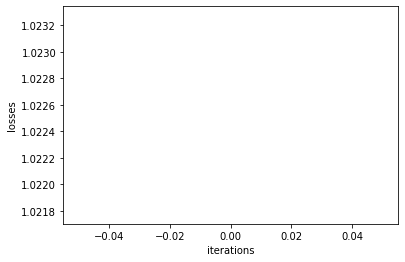

INFO:tensorflow:Restoring parameters from /content/UGRNN1
INFO:tensorflow:Restoring parameters from /content/UGRNN1
INFO:tensorflow:Restoring parameters from /content/UGRNN1
running joint optimizer



	Optimization complete to desired tolerance.
All FPS shape  600
Finding unique Fixedpoints
Found unique Fixedpoints with size  1
		initial_states: 0 outliers detected (of 600).
		fixed points: 0 outliers detected (of 1).
Distance outliers excluded, currently size 1
computing recurrent jacobians
batch jacobians
running cells
out of batch jacobians
Compute input Jacobians
decomposing Jacobians
decomposed Jacobians
saving
coming out
final size  1


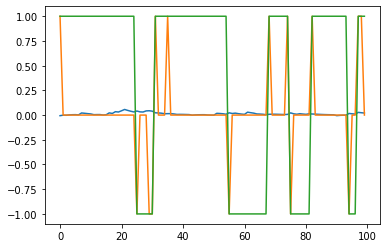

In [5]:
hps = {'lrate':1e-02,'decay':0.9,'moment':0.9,'norm':.5,'use_data':False,'epochs':1}
rnn = FlipFlop(c_type='UGRNN',l2=1e-02,**hps) 
rnn.state_size = 256
rnn.activation = 'relu'
%matplotlib inline
import seaborn as sns
rnn.train_network(1, save=True)
lis = rnn.reload_from_checkpoints('/content')
# plt.plot(lis['hiddens'].h[0,:])
rnn.run_validation()
rnn.fixed_points()

27
stable
stable
stable
stable
stable
stable
stable
stable


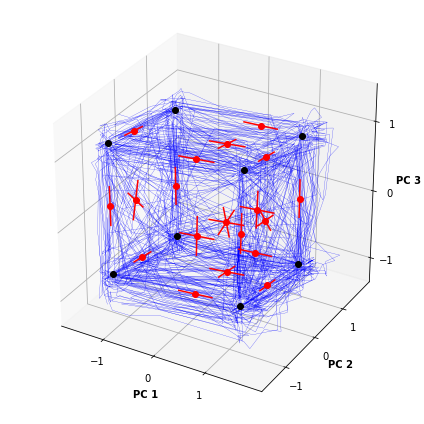

<Figure size 432x288 with 0 Axes>

In [7]:
from matplotlib.collections import LineCollection
from FixedPointStore import FixedPointStore
# from FixedPointSearch import FixedPointSearch
%matplotlib inline
from plot_utils import plot_fps
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
import os
import pickle
def restore(path):
	file = open(path,'rb')
	restore_data = file.read()
	file.close()

	hid= pickle.loads(restore_data,encoding='latin1')
	return(hid)
hid = restore(os.getcwd()+'/hiddens_.p')
fps = FixedPointStore(num_inits = 1,
				num_states= 1,
				num_inputs = 1)
dict_d = fps.restore(os.getcwd()+'/fixedPoint_unique.p')
fps.__dict__ = dict_d
print(fps.num_inits)
plot_fps(fps,
    hid,
    plot_batch_idx=range(30),
      plot_start_time=0)

In [40]:
rnn.fps.sample_states(1000,hid,'GRU',0.0)
hidden = rnn.fps.sampled_states


results = cca_core.get_cca_similarity(hidden.T, hidden.T, epsilon=1e-10, verbose=True)
mean = np.mean(results["cca_coef1"])


adding eps to diagonal and taking inverse
taking square root
dot products...
trying to take final svd
computed everything!
Mean CCA similarity 0.9999162470575433


In [ ]:

lis = rnn.reload_from_checkpoints('/content')
fps = FixedPointStore(num_inits = 1,
        num_states= 1,
        num_inputs = 1)
dict_d = fps.restore(os.getcwd()+'/fps_saver/fixedPoint_unique.p')
fps.__dict__ = dict_d
trans = np.zeros([fps.num_inits,fps.num_inits])

for y in range(20):
  print(y)
  fixed_points = fps.xstar

  fps_w_noise = fps.xstar+1e-01*np.random.randn(fixed_points.shape[0],fixed_points.shape[1])


  init_state = tf.convert_to_tensor(fps_w_noise, dtype=tf.float32)


  x = tf.placeholder(tf.float32, [fps.num_inits, rnn.time, rnn.bits], name='input_placeholder')

  if rnn.c_type =='LSTM':
    init_state = rnn.fps.convert_to_lstm_tuples(init_state)
    rnn_outs= rnn.unroll_LSTM(rnn.cell, x,initial_state=init_state)
  else:
    rnn_outs,_= tf.nn.dynamic_rnn(rnn.cell,x,initial_state=init_state)

  zero_inpt = np.zeros((fps.num_inits, rnn.time, rnn.bits))
  hids = rnn.sess.run(rnn_outs, feed_dict={x:zero_inpt})
  
  if rnn.c_type =='LSTM':
    hids = rnn.fps.convert_from_lstm_tuples(hids)
  for l in range(fps.num_inits):
    for j in range(fps.num_inits):
      index = slice(j,j+1)
      inits_ = fixed_points[index]

      if np.linalg.norm(inits_-hids[l,99,:])<0.01:
        trans[l,j]+=1
import seaborn as sns 
sns.heatmap(trans,cmap='rainbow',vmin=0)


NameError: ignored

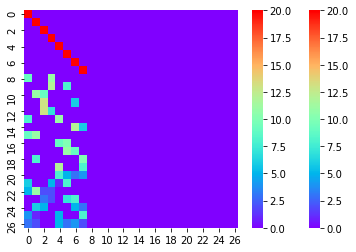

In [ ]:

def restore(path):
	file = open(path,'rb')
	restore_data = file.read()
	file.close()

	hid= pickle.loads(restore_data,encoding='latin1')
	return(hid)
a = restore('/content/transit.p')
m = a
import seaborn as sns 
sns.heatmap(a,cmap='rainbow')

temp1 = []
temp2 = []
temp3 = []
temp4 = []


ind  = []
for i in range(a.shape[0]):
  if np.count_nonzero(a[i]) ==1:
    temp1.append(a[i])
  elif np.count_nonzero(a[i])==2:
    temp2.append(a[i])
  elif np.count_nonzero(a[i])==4:
    temp3.append(a[i])
  else:
    temp4.append(a[i])
glf = np.concatenate((np.array(temp1),np.array(temp2),np.array(temp3),np.array(temp4)))
for i in range(glf.shape[1]):
  if np.count_nonzero(glf[i]) ==1:
    ind.append(glf[:,np.argmax(glf[i])])
y = glf.shape[0]-len(ind)
final = np.concatenate((np.array(ind).T,np.zeros((glf.shape[0],y))),axis=1)
sns.heatmap(final,cmap='rainbow')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


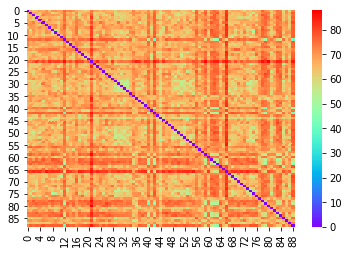

In [ ]:
def restore(path):
	file = open(path,'rb')
	restore_data = file.read()
	file.close()

	hid= pickle.loads(restore_data,encoding='latin1')
	return(hid)
m = restore('/content/distance_matrix.p')
import seaborn as sns
ax = []
ax_ = []
for i in range(m.shape[0]):
  if np.sum(m[i,:]) == 0.0:
    ax.append(i)
  a = np.delete(m,ax,axis=0)
  a = np.delete(a,ax,axis=1)
    
sns.heatmap(a,cmap='rainbow')


In [ ]:
def hps_array():
  arch  = ['Vanilla', 'UGRNN', 'GRU', 'LSTM']
  activ = ['tanh' , 'relu']
  units = [64, 128, 256 ]
  l2_norm = [1e-5, 1e-4, 1e-3, 1e-2]
  hps_dict = {'arch':arch,
              'activ':activ,
              'units':units,
              'l2_norm':l2_norm}

  hps_array = []
  # adp_lr = {'initial_rate': 1.0, 'min_rate': 1e-5}
  for i in arch:
    for j in activ:
      for k in units:
        for l in l2_norm:
          hps_array.append({'arch':i,
                            'activ':j,
                            'units':k,
                            'l2_norm':l,
                            'seed':400})
  return hps_array  


/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


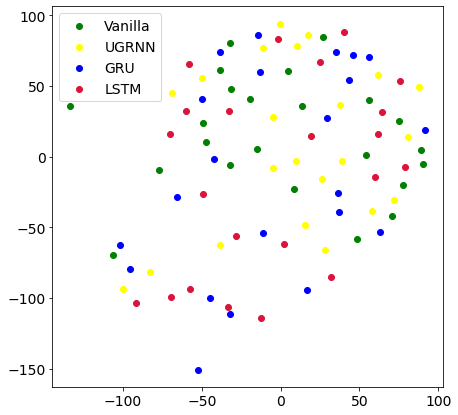

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler
def restore(path):
	file = open(path,'rb')
	restore_data = file.read()
	file.close()

	hid= pickle.loads(restore_data,encoding='latin1')
	return(hid)

mask = []
mask_rec = []
mask_N = []

for i in hps_array():
    if i['arch'] == 'Vanilla':
      mask.append(0)
    if i['arch']=='UGRNN':
      mask.append(1)
    if i['arch']=='GRU':
      mask.append(2)
    if i['arch']=='LSTM':
      mask.append(3)
for i in hps_array():
    if i['activ'] == 'relu':
      mask_rec.append(0)
    if i['activ'] == 'tanh':
      mask_rec.append(1)
for i in hps_array():
  if i['units'] == 256:
    mask_N.append(0)
  if i['units'] == 128:
    mask_N.append(1)
  if i['units'] == 64:
    mask_N.append(2)

mask = np.array(mask)
mask_rec= np.array(mask_rec)
m = restore('/content/distance_matrix.p')
import seaborn as sns
ax = []
for i in range(m.shape[0]):
  if np.sum(m[i,:]) == 0.0:
    ax.append(i)
  data = np.delete(m,ax,axis=0)
  data = np.delete(data,ax,axis=1)
  mask_ = np.delete(mask,ax,axis=0)
  mask_rec_ = np.delete(mask_rec,ax,axis=0)
  mask_N_ = np.delete(mask_N,ax,axis=0)
X = data
mds = MDS(2,random_state=0)
X_2d = mds.fit_transform(X)
colors = ['green','yellow','blue','crimson']
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
names = ['Vanilla','UGRNN','GRU','LSTM']
for i in np.unique(mask_):

  subset = X_2d[mask_ == i]
  x = [row[0] for row in subset]
  y = [row[1] for row in subset]
  
  plt.scatter(x,y,c=colors[i],label=names[i])
  plt.legend()
plt.show()


/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


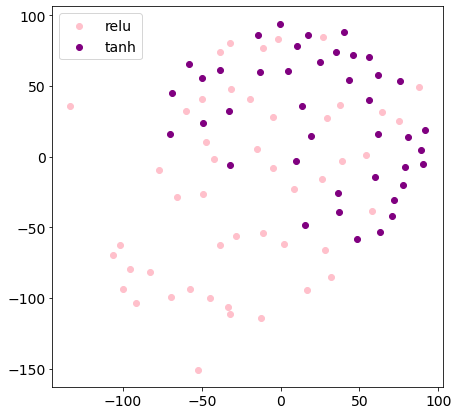

In [ ]:
X = data

mds = MDS(2,random_state=0)
X_2d = mds.fit_transform(X)

colors = ['pink','purple']
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
names = ['relu','tanh']
for i in np.unique(mask_rec_):

  subset = X_2d[mask_rec_ == i]
  x = [row[0] for row in subset]
  y = [row[1] for row in subset]
  
  plt.scatter(x,y,c=colors[i],label=names[i])
  plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


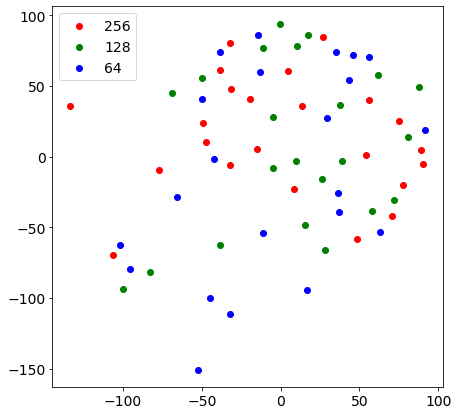

In [ ]:
X = data
mds = MDS(2,random_state=0)
X_2d = mds.fit_transform(X)
colors = ['red','green','blue']
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
names = ['256','128','64']
for i in np.unique(mask_N_):

  subset = X_2d[mask_ == i]
  x = [row[0] for row in subset]
  y = [row[1] for row in subset]
  
  plt.scatter(x,y,c=colors[i],label=names[i])
  plt.legend()
plt.show()
